In [1]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
x_test, y_test = load_cifar10(n_examples=50)

In [3]:
x_test

tensor([[[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
          [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
          [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
          ...,
          [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
          [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
          [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

         [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
          [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
          [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
          ...,
          [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
          [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
          [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

         [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
          [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
          [0.1843, 0.1294, 0.1412,  ..., 0

In [5]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [6]:
trainloader, testloader = load_cifar10()

In [8]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,638,794


In [11]:
# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

In [12]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=5)


Starting training...
Training on mps
Epoch: 1/5, Batch: 0, Loss: 2.3077, Acc: 5.47%
Epoch: 1/5, Batch: 100, Loss: 1.6742, Acc: 23.19%
Epoch: 1/5, Batch: 200, Loss: 1.5692, Acc: 29.04%
Epoch: 1/5, Batch: 300, Loss: 1.4281, Acc: 33.58%
Epoch 1 completed: Loss: 1.7000, Accuracy: 36.75%
Epoch: 2/5, Batch: 0, Loss: 1.4179, Acc: 49.22%
Epoch: 2/5, Batch: 100, Loss: 1.2364, Acc: 51.96%
Epoch: 2/5, Batch: 200, Loss: 1.1811, Acc: 53.76%
Epoch: 2/5, Batch: 300, Loss: 1.1090, Acc: 55.48%
Epoch 2 completed: Loss: 1.2020, Accuracy: 56.78%
Epoch: 3/5, Batch: 0, Loss: 1.1233, Acc: 60.16%
Epoch: 3/5, Batch: 100, Loss: 0.9750, Acc: 64.37%
Epoch: 3/5, Batch: 200, Loss: 1.2087, Acc: 64.55%
Epoch: 3/5, Batch: 300, Loss: 0.9650, Acc: 65.33%
Epoch 3 completed: Loss: 0.9600, Accuracy: 65.82%
Epoch: 4/5, Batch: 0, Loss: 0.8328, Acc: 70.31%
Epoch: 4/5, Batch: 100, Loss: 0.6660, Acc: 69.40%
Epoch: 4/5, Batch: 200, Loss: 0.6872, Acc: 69.95%
Epoch: 4/5, Batch: 300, Loss: 0.9209, Acc: 70.74%
Epoch 4 completed: Lo

In [16]:
# Evaluation function
def evaluate_model(model, testloader):
    device = 'mps'
    model.eval()
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_acc = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
    
    print('\nPer-class accuracies:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return overall_acc

In [19]:
# Visualization function
def show_sample_predictions(model, testloader, num_samples=8):
    device = 'mps'
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Denormalize for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)
        
        # Denormalize image
        img = images[i].cpu() * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        plt.imshow(img)
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Evaluating model...

Overall Test Accuracy: 76.86%

Per-class accuracies:
plane: 83.50%
car: 93.60%
bird: 55.60%
cat: 70.40%
deer: 75.10%
dog: 68.70%
frog: 85.30%
horse: 79.90%
ship: 74.30%
truck: 82.20%


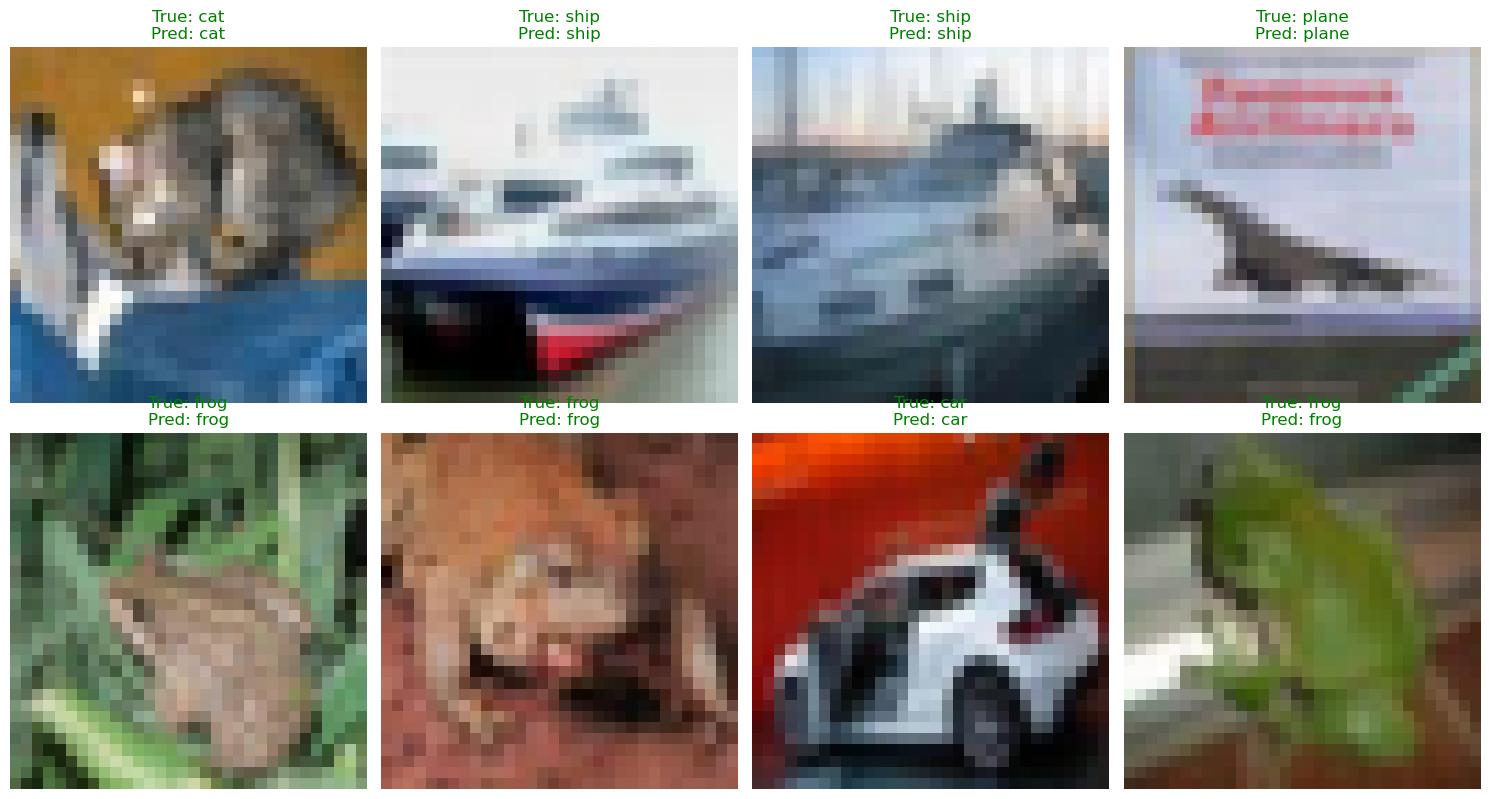

In [20]:
# Evaluate model
print("\nEvaluating model...")
test_accuracy = evaluate_model(model, testloader)

# Show sample predictions
show_sample_predictions(model, testloader)